In [1]:
from pathlib import Path
import numpy as np
from skimage.transform import resize
import torchaudio
import librosa
import matplotlib.pyplot as plt
from scipy import linalg as la

In [2]:
file_dir = "/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/"
wav_files = [x for x in Path(file_dir).glob("**/*") if "WAV" in str(x)]
wav_files[:5]

[PosixPath('/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/files210/121223032721202117.WAV'),
 PosixPath('/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/files210/121216020358185718.WAV'),
 PosixPath('/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/files210/121216200753666913.WAV'),
 PosixPath('/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/files210/121215122312458486.WAV'),
 PosixPath('/home/jupyter/data/egyptian_fruit_bat_annotated_tiny/files210/121217012416173033.WAV')]

The Constant-Q Transform:
---

I've decided to settle on the [CQ](https://en.wikipedia.org/wiki/Constant-Q_transform) transform, since it is closely to both the Fourier and Morlet wavelet transforms -- roughly capturing information present in both, though not as computationally expensive as a wavelet transform. It's also similar to the melspectrogram in that it distributes the signal into logarithmically spaced frequency bins! 

Since I'm not sure how to pick the right parameters for the transform, I'll use the following functions to search for optimal parameters. The optimization will be subject to information content of the CQT representation of an audio signal. I'll compute the information content of the CQ transform of the signal using Von Neumann entropy, which is just an extension of Shannon entropy:


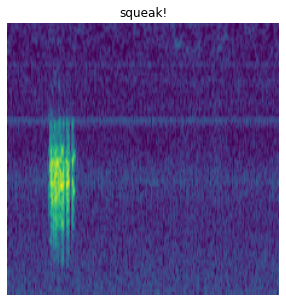

In [3]:
def get_cqt(path,  
            hop_length = 1024,
            n_bins = 93, 
            fmin = "C5"):
    
    x, rate = librosa.load(path, 
                           mono = True,
                           sr = None,
                           dtype = np.float32)

    spec = librosa.cqt(x,
                       sr = rate, 
                       fmin = librosa.note_to_hz(fmin),
                       hop_length=hop_length,
                       n_bins = n_bins)
    
    
    spec = librosa.amplitude_to_db(np.abs(spec), ref = np.max)
    spec = resize(spec, (225, 225))
    
    #spec = (spec - np.max(spec))
    spec = 255*(spec - np.min(spec))/(np.max(spec) - np.min(spec))
    
    return spec.astype(np.uint8)
    
def vn_entropy(arr):
    #thanks @pcbermant!
    eigenvals = la.eigvals(arr)
    eigenvals = np.array([x for x in eigenvals.tolist() if x])

    log2_eigenvals = np.matrix(np.log2(eigenvals))
    eigenvals = np.matrix(eigenvals)

    S = -np.dot(eigenvals, log2_eigenvals.H)
    vn = np.array(np.abs(S)).flatten()
    
    return vn[0]

def vn_ent_of_cqt(n_bins = 100,
                 hop_length = 512,
                 num_samples = 30):
    #computes average vn_ent of a cqt transform at the provided params
    ents = []
    for _ in range(num_samples) : 
        try:
            x = get_cqt(wav_files[np.random.randint(0, len(wav_files)-1)],
                        n_bins = n_bins, 
                        hop_length = hop_length)
            e = vn_entropy(x)
            ents.append(e)
        except:
            pass
    return np.mean(ents)

plt.figure(figsize = (5, 5))
plt.imshow(get_cqt(wav_files[0]))
plt.title("squeak!")
plt.axis("off")
plt.show()

The CQ transform takes a fundamental frequency from which `n_bins` frequency bins are stacked. We can represent the fundamental frequency using `librosa.note_to_hz("C3")`, where `"C3"` is middle "C" on a piano. The following plots show how the CQ transform of an audio signal is changed by varying fmin:

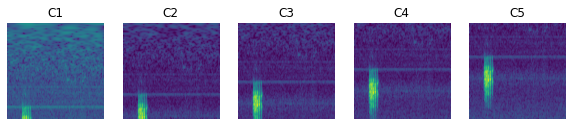

In [4]:
fmins = ["C1", "C2", "C3", "C4", "C5"]
fig, axs = plt.subplots(1, len(fmins), figsize = (10, 10))

for ax, f in zip(axs, fmins):
    ax.set_axis_off()
    ax.set_title(f)
    ax.imshow(get_cqt(wav_files[0], fmin = f))
    
plt.show()

Cool! It's important to note that the display convention has frequency decreasing vertically, and time increasing to the right-- and so we can intuitthat as we increase `fmin`, while keeping `n_bins` constant, we see more of the higher frequency components, and less of the lower frequency components of the squeak. Next, we just look at how the `hop_length` parameter affects a given signal:

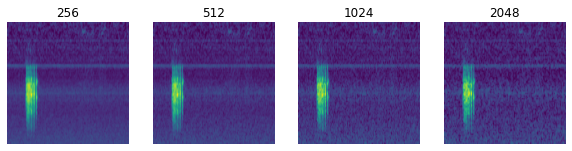

In [5]:
hop_lengths = [2**i for i in range(8, 12)]
fig, axs = plt.subplots(1, len(hop_lengths), figsize = (10, 10))

for ax, hop in zip(axs, hop_lengths):
    ax.set_axis_off()
    ax.set_title(hop)
    ax.imshow(get_cqt(wav_files[0], hop_length = hop))
plt.show()

And finally for the `n_bins` parameter, we see that as the number of bins are added, we see more of the higher frequency components

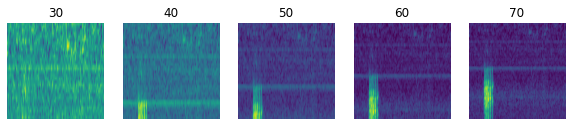

In [6]:
bins = np.arange(30, 80, 10)
fig, axs = plt.subplots(1, len(bins), figsize = (10, 10))

for ax, b in zip(axs, bins):
    ax.set_axis_off()
    ax.set_title(b)
    ax.imshow(get_cqt(wav_files[0], n_bins = int(b)))
plt.show()

When trying to optimize a computationally expensive function, it's known that a [random parameter search](https://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) performs better than a grid search, so that's what we'll do below:

In [7]:
#randomly sampling the parameter space
from tqdm import trange

import warnings
warnings.filterwarnings("ignore")

n = 250
params = []
ent_vals = []

for _ in trange(n):
    temp_x = np.random.randint(60, 140)
    temp_y = 2**np.random.randint(6, 11)
    
    try:
        e = vn_ent_of_cqt(hop_length = temp_y, 
                          n_bins = temp_x)
        ent_vals.append(e)
        params.append([temp_x, temp_y])
    except:
        pass
        

100%|██████████| 250/250 [45:47<00:00, 10.99s/it] 


Now let's look at the 2D parameter space and grab the approximate maximum:

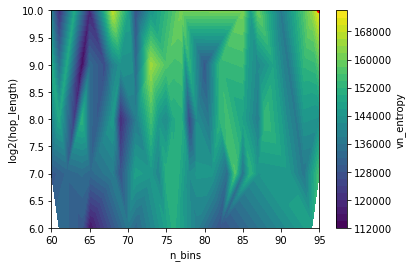

Maximum Entropy at 172427.1989328213
(n_bins, hop_length) = [  95 1024]


In [8]:
params = np.asarray(params)[~np.isnan(ent_vals)]
ent_vals = np.array(ent_vals)[~np.isnan(ent_vals)]

best_ind = np.argmax(ent_vals)

plt.tricontourf(params[:,0], 
                np.log2(params[:, 1]), 
                ent_vals, 30)
plt.colorbar(label = 'vn_entropy')

plt.scatter(params[best_ind][0], 
            np.log2(params[best_ind][1]), 
            c = 'r', s = 20)
plt.ylabel("log2(hop_length)")
plt.xlabel("n_bins")

plt.show()


print("Maximum Entropy at {}".format(ent_vals[best_ind]))
print("(n_bins, hop_length) = {}".format(params[best_ind]))

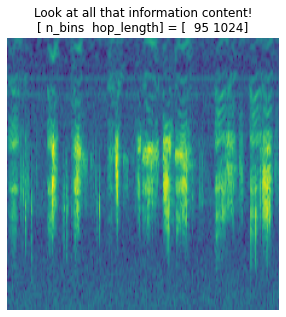

In [9]:
best_nbins, best_hopl = params[best_ind]
plt.figure(figsize = (5, 5))
plt.imshow(get_cqt(wav_files[10], 
                   n_bins = int(best_nbins), 
                   hop_length = best_hopl, 
                   fmin = "C5"))
plt.title("Look at all that information content!\n[ n_bins  hop_length] = {}".format(params[best_ind]))
plt.axis("off")
plt.show()